In [1]:
using Distributions
using Optim
using Roots
using StatsPlots
default(fmt=:png)

module O

using Distributions
using Optim
using Random
using Roots
using QuadGK

# RiskDifferenceDist

struct RiskDifferenceDist{T} <: ContinuousUnivariateDistribution
    beta1::Beta{T}
    beta2::Beta{T}
end

eltype(d::RiskDifferenceDist{T}) where T = T

function RiskDifferenceDist(a, b, c, d; prior1=Beta(1, 1), prior2=Beta(1, 1))
    κ, λ = params(prior1)
    μ, ν = params(prior2)
    RiskDifferenceDist(Beta(κ+a, λ+b), Beta(μ+c, ν+d))
end

Distributions.minimum(d::RiskDifferenceDist) = -1.0
Distributions.maximum(d::RiskDifferenceDist) = 1.0
Distributions.insupport(d::RiskDifferenceDist, x::Real) = minimum(d) ≤ x ≤ maximum(d)

function Random.rand(rng::AbstractRNG, d::RiskDifferenceDist)
    (; beta1, beta2) = d
    p, q = rand(rng, beta1), rand(rng, beta2)
    p - q
end

function Distributions.cdf(d::RiskDifferenceDist, δ::Real)
    (; beta1, beta2) = d
    q0, q1 = max(0, -δ), min(1, 1-δ)
    quadgk(q -> cdf(beta1, q+δ) * pdf(beta2, q), q0, q1)[1] + ccdf(beta2, q1)
end

function Distributions.cdf(d::RiskDifferenceDist, δ::Real)
    (; beta1, beta2) = d
    q0 = max(0, -δ)
    quadgk(q -> cdf(beta1, q+δ) * pdf(beta2, q), q0, 1)[1]
end

function Distributions.pdf(d::RiskDifferenceDist, δ::Real)
    (; beta1, beta2) = d
    q0, q1 = max(0, -δ), min(1, 1-δ)
    quadgk(q -> pdf(beta1, q+δ) * pdf(beta2, q), q0, q1)[1]
end

Distributions.logpdf(d::RiskDifferenceDist, δ::Real) = log(pdf(d, δ))

function Distributions.quantile(d::RiskDifferenceDist, p)
    @assert 0 ≤ p ≤ 1
    p == 0 && return minimum(d)
    p == 1 && return maximum(d)
    find_zero(δ -> cdf(d, δ) - p, (-1, 1))
end

Distributions.median(d::RiskDifferenceDist{T}) where T = quantile(d, 1/2)

mean_quadgk(d::RiskDifferenceDist) = 
    quadgk(δ -> δ * pdf(d, δ), -1, 1)[1]

function Distributions.mean(d::RiskDifferenceDist)
    (; beta1, beta2) = d
    mean(beta1) - mean(beta2)
end

var_quadgk(d::RiskDifferenceDist) = 
    quadgk(δ -> (δ - mean(d))^2 * pdf(d, δ), -1, 1)[1]

function Distributions.var(d::RiskDifferenceDist)
    (; beta1, beta2) = d
    var(beta1) + var(beta2)
end

function Distributions.mode(d::RiskDifferenceDist)
    o = optimize(δ -> -pdf(d, δ), -1, 1, Brent())
    o.minimizer
end

# RiskRatioDist

struct RiskRatioDist{T} <: ContinuousUnivariateDistribution
    beta1::Beta{T}
    beta2::Beta{T}
end

eltype(d::RiskRatioDist{T}) where T = T

function RiskRatioDist(a, b, c, d; prior1=Beta(1, 1), prior2=Beta(1, 1))
    κ, λ = params(prior1)
    μ, ν = params(prior2)
    RiskRatioDist(Beta(κ+a, λ+b), Beta(μ+c, ν+d))
end

Distributions.minimum(d::RiskRatioDist) = 0.0
Distributions.maximum(d::RiskRatioDist) = Inf
Distributions.insupport(d::RiskRatioDist, x::Real) = minimum(d) ≤ x ≤ maximum(d)

function Random.rand(rng::AbstractRNG, d::RiskRatioDist)
    (; beta1, beta2) = d
    p, q = rand(rng, beta1), rand(rng, beta2)
    p / q
end

function Distributions.cdf(d::RiskRatioDist, ρ::Real)
    (; beta1, beta2) = d
    quadgk(q -> cdf(beta1, ρ*q) * pdf(beta2, q), 0, 1)[1]
end

function Distributions.pdf(d::RiskRatioDist, ρ::Real)
    (; beta1, beta2) = d
    q1 = min(1, 1/ρ)
    quadgk(q -> q * pdf(beta1, ρ*q) * pdf(beta2, q), 0, q1)[1]
end

Distributions.logpdf(d::RiskRatioDist, ρ::Real) = log(pdf(d, ρ))

function Distributions.quantile(d::RiskRatioDist, p)
    @assert 0 ≤ p ≤ 1
    p == 0 && return minimum(d)
    p == 1 && return maximum(d)
    x = 1.0
    while cdf(d, x) < p
        x *= 2
    end
    find_zero(ρ -> cdf(d, ρ) - p, (0, x))
end

Distributions.median(d::RiskRatioDist{T}) where T = quantile(d, 1/2)

mean_quadgk(d::RiskRatioDist) = 
    quadgk(ρ -> ρ * pdf(d, ρ), 0, Inf)[1]

function Distributions.mean(d::RiskRatioDist)
    (; beta1, beta2) = d
    μ, ν = params(beta2)
    invbeta2 = 1 + BetaPrime(ν, μ)
    mean(beta1) * mean(invbeta2)
end

var_quadgk(d::RiskRatioDist) = 
    quadgk(ρ -> (ρ - mean(d))^2 * pdf(d, ρ), 0, Inf)[1]

function Distributions.var(d::RiskRatioDist)
    (; beta1, beta2) = d
    μ, ν = params(beta2)
    invbeta2 = 1 + BetaPrime(ν, μ)
    m1, m2 = mean(beta1), mean(invbeta2)
    (var(beta1) + m1^2)*(var(invbeta2) + m2^2) - m1^2*m2^2
end

function Distributions.mode(d::RiskRatioDist)
    x, y = 1.0, 2.0
    while pdf(d, x) ≤ pdf(d, y)
        x, y = 2x, 2y
    end
    o = optimize(ρ -> -pdf(d, ρ), 0, y, Brent())
    o.minimizer
end

# OddsRatioDist

struct OddsRatioDist{T} <: ContinuousUnivariateDistribution
    bp1::BetaPrime{T}
    bp2::BetaPrime{T}
end

eltype(d::OddsRatioDist{T}) where T = T

function OddsRatioDist(a, b, c, d; prior1=Beta(1, 1), prior2=Beta(1, 1))
    κ, λ = params(prior1)
    μ, ν = params(prior2)
    OddsRatioDist(BetaPrime(κ+a, λ+b), BetaPrime(μ+c, ν+d))
end

Distributions.minimum(d::OddsRatioDist) = 0.0
Distributions.maximum(d::OddsRatioDist) = Inf
Distributions.insupport(d::OddsRatioDist, x::Real) = minimum(d) ≤ x ≤ maximum(d)

function Random.rand(rng::AbstractRNG, d::OddsRatioDist)
    (; bp1, bp2) = d
    u, v = rand(rng, bp1), rand(rng, bp2)
    u / v
end

function Distributions.cdf(d::OddsRatioDist, ω::Real)
    (; bp1, bp2) = d
    quadgk(v -> cdf(bp1, ω*v) * pdf(bp2, v), 0, Inf)[1]
end

function Distributions.pdf(d::OddsRatioDist, ω::Real)
    (; bp1, bp2) = d
    quadgk(v -> v * pdf(bp1, ω*v) * pdf(bp2, v), 0, Inf)[1]
end

Distributions.logpdf(d::OddsRatioDist, ω::Real) = log(pdf(d, ω))

function Distributions.quantile(d::OddsRatioDist, p)
    @assert 0 ≤ p ≤ 1
    p == 0 && return minimum(d)
    p == 1 && return maximum(d)
    x = 1.0
    while cdf(d, x) < p
        x *= 2
    end
    find_zero(ω -> cdf(d, ω) - p, (0, x))
end

Distributions.median(d::OddsRatioDist{T}) where T = quantile(d, 1/2)

mean_quadgk(d::OddsRatioDist) = 
    quadgk(ω -> ω * pdf(d, ω), 0, Inf)[1]

function Distributions.mean(d::OddsRatioDist)
    (; bp1, bp2) = d
    μ, ν = params(bp2)
    invbp2 = BetaPrime(ν, μ)
    mean(bp1) * mean(invbp2)
end

var_quadgk(d::OddsRatioDist) = 
    quadgk(ω -> (ω - mean(d))^2 * pdf(d, ω), 0, Inf)[1]

function Distributions.var(d::OddsRatioDist)
    (; bp1, bp2) = d
    μ, ν = params(bp2)
    invbp2 = BetaPrime(ν, μ)
    m1, m2 = mean(bp1), mean(invbp2)
    (var(bp1) + m1^2)*(var(invbp2) + m2^2) - m1^2*m2^2
end

function Distributions.mode(d::OddsRatioDist)
    x, y = 1.0, 2.0
    while pdf(d, x) ≤ pdf(d, y)
        x, y = 2x, 2y
    end
    o = optimize(ω -> -pdf(d, ω), 0, y, Brent())
    o.minimizer
end

end

# pvalue functions

pvalue_eti(dist::ContinuousUnivariateDistribution, x) =
    min(2cdf(dist, x), 2ccdf(dist, x))

function pvalue_hdi(dist::ContinuousUnivariateDistribution, x)
    distmin, distmax = extrema(dist)
    (x ≤ distmin || distmax ≤ x) && return 0.0
    m = mode(dist)
    px = pdf(dist, x)
    if pdf(dist, m) ≈ px
        1.0
    elseif x < m
        z = if distmax < Inf
            distmax
        else
            h = 1.0
            while pdf(dist, m + h) ≥ px
                h *= 2
            end
            m + h
        end
        y = find_zero(y -> pdf(dist, y) - px, (m, z))
        cdf(dist, x) + ccdf(dist, y)
    else
        z = if distmin > -Inf
            distmin
        else
            h = 1.0
            while pdf(dist, m - h) ≥ px
                h *= 2
            end
            m - h
        end
        y = find_zero(y -> pdf(dist, y) - px, (z, m))
        cdf(dist, y) + ccdf(dist, x)
    end
end

# compatibility interval functions

function equal_tailed_interval(dist, α=0.05)
    L, U = quantile(dist, α/2), cquantile(dist, α/2)
    [L, U]
end

function highest_density_interval(dist, α=0.05)
    α == 0 && return [minimum(dist),  maximum(dist)]
    α == 1 && return fill(mode(dist), 2)
    f(t) = quantile(dist, t + (1 - α)) - quantile(dist, t)
    o = optimize(f, 0, α, Brent())
    t_L = o.minimizer
    L, U = quantile(dist, t_L), quantile(dist, t_L + (1 - α))
    [L, U]
end

highest_density_interval (generic function with 2 methods)

(κ, λ, μ, ν) = (1, 1, 1, 1)
(a, b, c, d) = (15, 5, 13, 15)
dist = O.RiskDifferenceDist(a, b, c, d; prior1 = Beta(κ, λ), prior2 = Beta(μ, ν)) = Main.O.RiskDifferenceDist{Float64}(
beta1: Beta{Float64}(α=16.0, β=6.0)
beta2: Beta{Float64}(α=14.0, β=16.0)
)

a / (a + b) - c / (c + d) = 0.2857142857142857
(κ + a) / (κ + a + λ + b) - (μ + c) / (μ + c + ν + d) = 0.2606060606060606
me = median(dist) = 0.2643697366741105
mo = mode(dist) = 0.2722198177005964
δ = quantile(dist, 0.975) = 0.5020676056725477
cdf(dist, δ) = 0.975
O.mean_quadgk(dist) = 0.26060606060606056
mean(dist) = 0.2606060606060606
O.var_quadgk(dist) = 0.01665246111503921
var(dist) = 0.016652461115039208
std(dist) = 0.12904441528031815


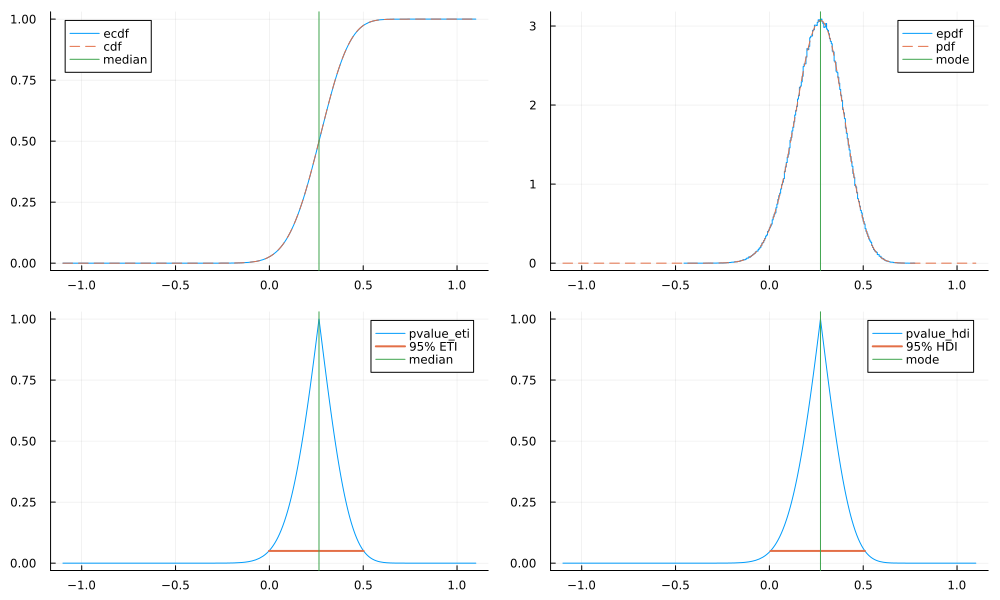

In [2]:
κ, λ, μ, ν = 1, 1, 1, 1
@show κ, λ, μ, ν
a, b, c, d = 15, 5, 13, 15
#a, b, c, d = 13, 15, 15, 5
@show a, b, c, d
@show dist = O.RiskDifferenceDist(a, b, c, d; prior1=Beta(κ,λ), prior2=Beta(μ,ν))
@show a/(a+b) - c/(c+d)
@show (κ+a)/(κ+a+λ+b) - (μ+c)/(μ+c+ν+d)
@show me = median(dist)
@show mo = mode(dist)
@show δ = quantile(dist, 0.975)
@show cdf(dist, δ)
@show O.mean_quadgk(dist)
@show mean(dist)
@show O.var_quadgk(dist)
@show var(dist)
@show std(dist)

L = 10^6
RDsample = rand(dist, L)

P = plot(δ -> count(≤(δ), RDsample)/length(RDsample), -1.1, 1.1; label="ecdf")
plot!(δ -> cdf(dist, δ); label="cdf", ls=:dash)
vline!([me]; label="median")

Q = stephist(RDsample; norm=true, label="epdf")
plot!(δ -> pdf(dist, δ), -1.1, 1.1; label="pdf", ls=:dash)
vline!([mo]; label="mode")

R = plot(δ -> pvalue_eti(dist, δ), -1.1, 1.1; label="pvalue_eti")
plot!(equal_tailed_interval(dist), fill(0.05, 2); label="95% ETI", lw=2)
vline!([me]; label="median")

S = plot(δ -> pvalue_hdi(dist, δ), -1.1, 1.1; label="pvalue_hdi")
plot!(highest_density_interval(dist), fill(0.05, 2); label="95% HDI", lw=2)
vline!([mo]; label="mode")

plot(P, Q, R, S; size=(1000, 600), layout=(2, 2))

(κ, λ, μ, ν) = (1, 1, 1, 1)
(a, b, c, d) = (15, 5, 13, 15)
dist = O.RiskRatioDist(a, b, c, d; prior1 = Beta(κ, λ), prior2 = Beta(μ, ν)) = Main.O.RiskRatioDist{Float64}(
beta1: Beta{Float64}(α=16.0, β=6.0)
beta2: Beta{Float64}(α=14.0, β=16.0)
)

(a / (a + b)) / (c / (c + d)) = 1.6153846153846154
((κ + a) / (κ + a + λ + b)) / ((μ + c) / (μ + c + ν + d)) = 1.5584415584415585
me = median(dist) = 1.564259770953546
mo = mode(dist) = 1.467644170342015
ρ = quantile(dist, 0.975) = 2.5853804772055557
cdf(dist, ρ) = 0.975
O.mean_quadgk(dist) = 1.6223776223776225
mean(dist) = 1.6223776223776225
O.var_quadgk(dist) = 0.16590443103060792
var(dist) = 0.1659044310306097
std(dist) = 0.40731367645907707


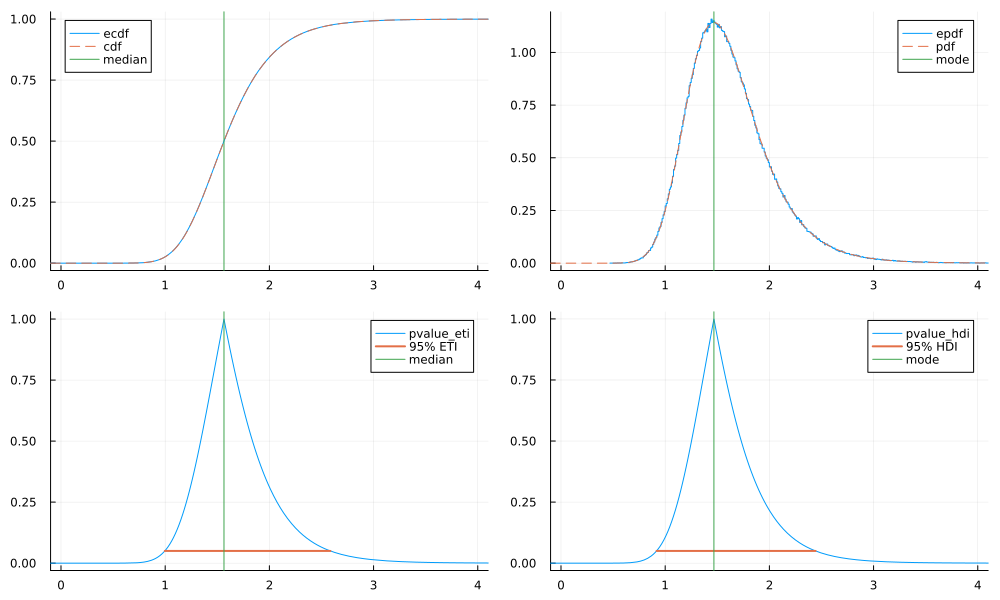

In [3]:
κ, λ, μ, ν = 1, 1, 1, 1
@show κ, λ, μ, ν
a, b, c, d = 15, 5, 13, 15
#a, b, c, d = 13, 15, 15, 5
@show a, b, c, d
@show dist = O.RiskRatioDist(a, b, c, d; prior1=Beta(κ,λ), prior2=Beta(μ,ν))
@show (a/(a+b)) / (c/(c+d))
@show ((κ+a)/(κ+a+λ+b)) / ((μ+c)/(μ+c+ν+d))
@show me = median(dist)
@show mo = mode(dist)
@show ρ = quantile(dist, 0.975)
@show cdf(dist, ρ)
@show O.mean_quadgk(dist)
@show mean(dist)
@show O.var_quadgk(dist)
@show var(dist)
@show std(dist)

L = 10^6
RRsample = rand(dist, L)

P = plot(ρ -> count(≤(ρ), RRsample)/length(RRsample), -0.1, 4.1; label="ecdf")
plot!(ρ -> cdf(dist, ρ); label="cdf", ls=:dash)
vline!([me]; label="median")
plot!(xlim=(-0.1, 4.1))

Q = stephist(RRsample; norm=true, label="epdf")
plot!(ρ -> pdf(dist, ρ), -0.1, 4.1; label="pdf", ls=:dash)
vline!([mo]; label="mode")
plot!(xlim=(-0.1, 4.1))

R = plot(ρ -> pvalue_eti(dist, ρ), -0.1, 4.1; label="pvalue_eti")
plot!(equal_tailed_interval(dist), fill(0.05, 2); label="95% ETI", lw=2)
vline!([me]; label="median")
plot!(xlim=(-0.1, 4.1))

S = plot(ρ -> pvalue_hdi(dist, ρ), -0.1, 4.1; label="pvalue_hdi")
plot!(highest_density_interval(dist), fill(0.05, 2); label="95% HDI", lw=2)
vline!([mo]; label="mode")
plot!(xlim=(-0.1, 4.1))

plot(P, Q, R, S; size=(1000, 600), layout=(2, 2))

(κ, λ, μ, ν) = (1, 1, 1, 1)
(a, b, c, d) = (15, 5, 13, 15)
dist = O.OddsRatioDist(a, b, c, d; prior1 = Beta(κ, λ), prior2 = Beta(μ, ν)) = Main.O.OddsRatioDist{Float64}(
bp1: BetaPrime{Float64}(α=16.0, β=6.0)
bp2: BetaPrime{Float64}(α=14.0, β=16.0)
)

(a / b) / (c / d) = 3.4615384615384612
((κ + a) / ((λ + b) - 1)) / (((μ + c) - 1) / (ν + d)) = 3.9384615384615387
me = median(dist) = 3.1915068883292186
mo = mode(dist) = 2.174851239626327
ω = quantile(dist, 0.975) = 11.31541904754888
cdf(dist, ω) = 0.9750000000000001
O.mean_quadgk(dist) = 3.9384615384615382
mean(dist) = 3.9384615384615387
O.var_quadgk(dist) = 8.201341222879677
var(dist) = 8.201341222879684
std(dist) = 2.863798390753037


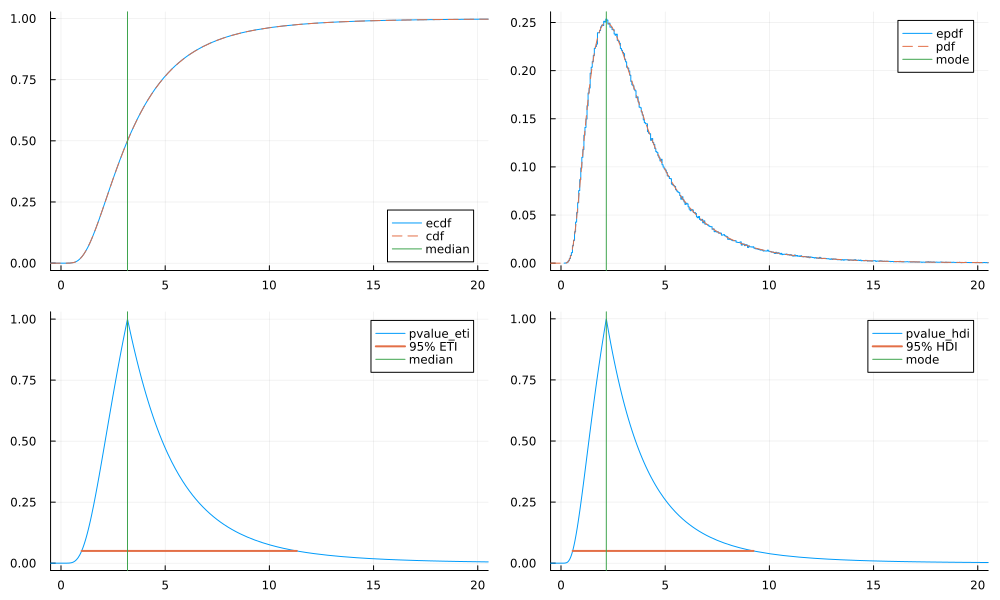

In [4]:
κ, λ, μ, ν = 1, 1, 1, 1
@show κ, λ, μ, ν
a, b, c, d = 15, 5, 13, 15
#a, b, c, d = 13, 15, 15, 5
@show a, b, c, d
@show dist = O.OddsRatioDist(a, b, c, d; prior1=Beta(κ,λ), prior2=Beta(μ,ν))
@show (a/b) / (c/d)
@show ((κ+a)/(λ+b-1)) / ((μ+c-1)/(ν+d))
@show me = median(dist)
@show mo = mode(dist)
@show ω = quantile(dist, 0.975)
@show cdf(dist, ω)
@show O.mean_quadgk(dist)
@show mean(dist)
@show O.var_quadgk(dist)
@show var(dist)
@show std(dist)

L = 10^6
ORsample = rand(dist, L)

P = plot(ω -> count(≤(ω), ORsample)/length(ORsample), -0.5, 20.5; label="ecdf")
plot!(ω -> cdf(dist, ω); label="cdf", ls=:dash)
vline!([me]; label="median")
plot!(xlim=(-0.5, 20.5))

Q = stephist(ORsample; norm=true, label="epdf")
plot!(ω -> pdf(dist, ω), -0.5, 20.5; label="pdf", ls=:dash)
vline!([mo]; label="mode")
plot!(xlim=(-0.5, 20.5))

R = plot(ω -> pvalue_eti(dist, ω), -0.5, 20.5; label="pvalue_eti")
plot!(equal_tailed_interval(dist), fill(0.05, 2); label="95% ETI", lw=2)
vline!([me]; label="median")
plot!(xlim=(-0.5, 20.5))

S = plot(ω -> pvalue_hdi(dist, ω), -0.5, 20.5; label="pvalue_hdi")
plot!(highest_density_interval(dist), fill(0.05, 2); label="95% HDI", lw=2)
vline!([mo]; label="mode")
plot!(xlim=(-0.5, 20.5))

plot(P, Q, R, S; size=(1000, 600), layout=(2, 2))

(κ, λ, μ, ν) = (1, 1, 1, 1)
(a, b, c, d) = (2, 23, 2, 38)
dist = O.RiskDifferenceDist(a, b, c, d; prior1 = Beta(κ, λ), prior2 = Beta(μ, ν)) = Main.O.RiskDifferenceDist{Float64}(
beta1: Beta{Float64}(α=3.0, β=24.0)
beta2: Beta{Float64}(α=3.0, β=39.0)
)

a / (a + b) - c / (c + d) = 0.03
(κ + a) / (κ + a + λ + b) - (μ + c) / (μ + c + ν + d) = 0.03968253968253968
me = median(dist) = 0.03487858026373067
mo = mode(dist) = 0.02395527397353329
δ = quantile(dist, 0.975) = 0.193563813827261
cdf(dist, δ) = 0.975
O.mean_quadgk(dist) = 0.03968253968253964
mean(dist) = 0.03968253968253968
O.var_quadgk(dist) = 0.005069814316768907
var(dist) = 0.005069814316768912
std(dist) = 0.07120262858047385
α = 0.06 = 0.06
eti = equal_tailed_interval(dist, α) = [-0.08516895793598037, 0.18605529119512423]
hdi = highest_density_interval(dist, α) = [-0.09087244386887088, 0.17939356417393612]


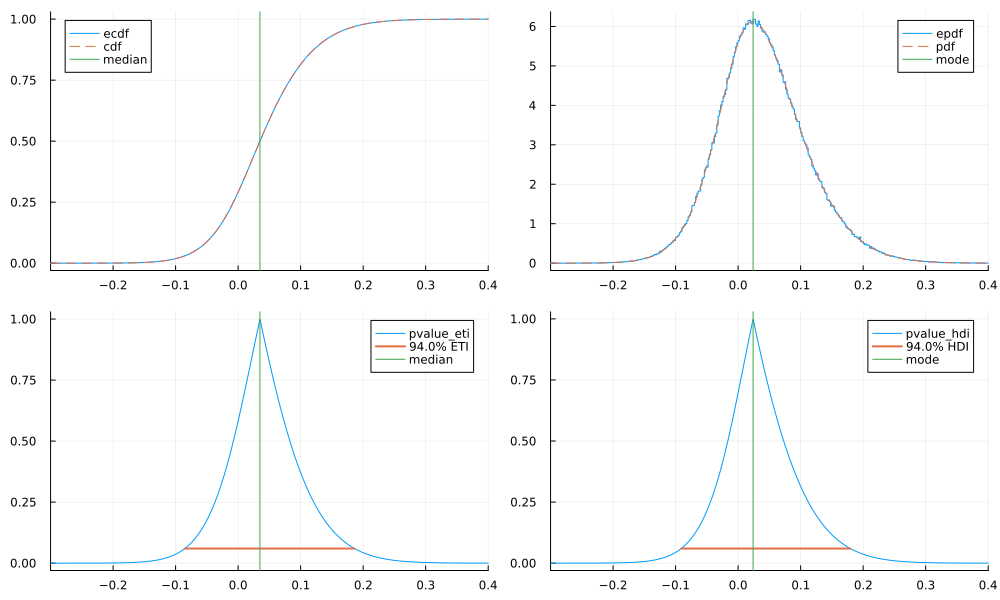

In [5]:
κ, λ, μ, ν = 1, 1, 1, 1
@show κ, λ, μ, ν
a, b, c, d = 2, 25-2, 2, 40-2
@show a, b, c, d
@show dist = O.RiskDifferenceDist(a, b, c, d; prior1=Beta(κ,λ), prior2=Beta(μ,ν))
@show a/(a+b) - c/(c+d)
@show (κ+a)/(κ+a+λ+b) - (μ+c)/(μ+c+ν+d)
@show me = median(dist)
@show mo = mode(dist)
@show δ = quantile(dist, 0.975)
@show cdf(dist, δ)
@show O.mean_quadgk(dist)
@show mean(dist)
@show O.var_quadgk(dist)
@show var(dist)
@show std(dist)
@show α = 0.06
@show eti = equal_tailed_interval(dist, α)
@show hdi = highest_density_interval(dist, α)

L = 10^6
RDsample = rand(dist, L)

P = plot(δ -> count(≤(δ), RDsample)/length(RDsample), -1.1, 1.1; label="ecdf")
plot!(δ -> cdf(dist, δ); label="cdf", ls=:dash)
vline!([me]; label="median")

Q = stephist(RDsample; norm=true, label="epdf")
plot!(δ -> pdf(dist, δ), -1.1, 1.1; label="pdf", ls=:dash)
vline!([mo]; label="mode")

R = plot(δ -> pvalue_eti(dist, δ), -1.1, 1.1; label="pvalue_eti")
plot!(eti, fill(α, 2); label="$(100(1-α))% ETI", lw=2)
vline!([me]; label="median")

S = plot(δ -> pvalue_hdi(dist, δ), -1.1, 1.1; label="pvalue_hdi")
plot!(hdi, fill(α, 2); label="$(100(1-α))% HDI", lw=2)
vline!([mo]; label="mode")

plot(P, Q, R, S; size=(1000, 600), layout=(2, 2))
plot!(xlim=(-0.3, 0.4))

(κ, λ, μ, ν) = (1, 1, 1, 1)
(a, b, c, d) = (110, 1490, 60, 1140)
dist = O.RiskDifferenceDist(a, b, c, d; prior1 = Beta(κ, λ), prior2 = Beta(μ, ν)) = Main.O.RiskDifferenceDist{Float64}(
beta1: Beta{Float64}(α=111.0, β=1491.0)
beta2: Beta{Float64}(α=61.0, β=1141.0)
)

a / (a + b) - c / (c + d) = 0.018750000000000003
(κ + a) / (κ + a + λ + b) - (μ + c) / (μ + c + ν + d) = 0.018539637433241732
me = median(dist) = 0.018573665713708665
mo = mode(dist) = 0.018641006035265025
δ = quantile(dist, 0.975) = 0.0360209154305493
cdf(dist, δ) = 0.975
O.mean_quadgk(dist) = 0.01853963743324149
mean(dist) = 0.018539637433241732
O.var_quadgk(dist) = 8.027358240506427e-5
var(dist) = 8.027358240506705e-5
std(dist) = 0.008959552578397376
α = 0.06 = 0.06
eti = equal_tailed_interval(dist, α) = [0.001591267814546653, 0.035315163643834586]
hdi = highest_density_interval(dist, α) = [0.0016596341075796432, 0.035382564511688044]


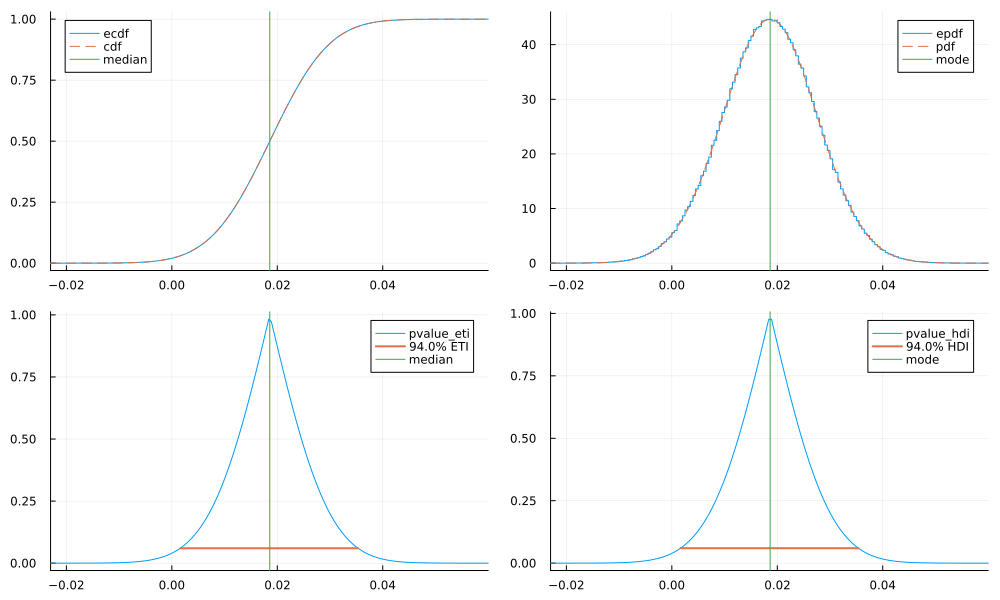

In [6]:
κ, λ, μ, ν = 1, 1, 1, 1
@show κ, λ, μ, ν
a, b, c, d = 110, 1600-110, 60, 1200-60
@show a, b, c, d
@show dist = O.RiskDifferenceDist(a, b, c, d; prior1=Beta(κ,λ), prior2=Beta(μ,ν))
@show a/(a+b) - c/(c+d)
@show (κ+a)/(κ+a+λ+b) - (μ+c)/(μ+c+ν+d)
@show me = median(dist)
@show mo = mode(dist)
@show δ = quantile(dist, 0.975)
@show cdf(dist, δ)
@show O.mean_quadgk(dist)
@show mean(dist)
@show O.var_quadgk(dist)
@show var(dist)
@show std(dist)
@show α = 0.06
@show eti = equal_tailed_interval(dist, α)
@show hdi = highest_density_interval(dist, α)

L = 10^6
RDsample = rand(dist, L)

P = plot(δ -> count(≤(δ), RDsample)/length(RDsample), -1.1, 1.1; label="ecdf")
plot!(δ -> cdf(dist, δ); label="cdf", ls=:dash)
vline!([me]; label="median")

Q = stephist(RDsample; norm=true, label="epdf")
plot!(δ -> pdf(dist, δ), -1.1, 1.1; label="pdf", ls=:dash)
vline!([mo]; label="mode")

R = plot(δ -> pvalue_eti(dist, δ), -1.1, 1.1; label="pvalue_eti")
plot!(eti, fill(α, 2); label="$(100(1-α))% ETI", lw=2)
vline!([me]; label="median")

S = plot(δ -> pvalue_hdi(dist, δ), -1.1, 1.1; label="pvalue_hdi")
plot!(hdi, fill(α, 2); label="$(100(1-α))% HDI", lw=2)
vline!([mo]; label="mode")

plot(P, Q, R, S; size=(1000, 600), layout=(2, 2))
plot!(xlim=(-0.023, 0.06))